# **Project Title: Integrated Retail Analytics for Store Optimization**

**By Shubham Pandey**

### **Domain: Clustering**

### **Problem Statement:** Utilize ML and DA techniques to optimize store performance, forecasting demands, and enhance customer experience through segmentation and personalized marketing strategies.

### **Project Summary:**

This project focuses on Integrated Retail Analytics for Store Optimization using Walmart’s sales, store, and feature datasets. The objective was to combine data-driven insights with machine learning to improve retail decision-making.

Data Preparation & Integration: Merged sales, store, and external feature datasets, handled missing values, and engineered time-based features.

Exploratory Data Analysis (EDA): Identified seasonal trends, holiday sales spikes, the impact of markdowns, and performance differences across store types and sizes.

Customer Segmentation: Applied clustering to group departments into distinct demand segments (high-revenue, medium-demand, seasonal, and low-demand), enabling better inventory and marketing strategies.

Market Basket Analysis: Discovered frequent co-purchase patterns between departments, highlighting opportunities for cross-selling, bundling, and layout optimization.

Demand Forecasting: Built predictive models (Linear Regression, Random Forest, XGBoost). Random Forest and XGBoost achieved high accuracy (R² ≈ 0.97), making them effective tools for forecasting weekly sales.

📌 Outcome: The project delivers actionable insights that can help retailers optimize inventory, plan promotions, enhance cross-selling, and forecast demand with high accuracy, leading to improved operational efficiency and revenue growth.

## **Imports**

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import fpgrowth, association_rules
import networkx as nx
import pyfpgrowth

## **Data Loading & First Look**

In [3]:
# Data Loading
features = pd.read_csv('data\Features data set.csv')
sales = pd.read_csv('data\sales data-set.csv')
stores = pd.read_csv('data\stores data-set.csv')

In [5]:
# Displaying the head
display(features.head())
display(sales.head())
display(stores.head())

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
# Displaying the info
display(features.info())
display(sales.info())
display(stores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


None

## **Integrating the 3 datasets**

In [8]:
# 1. Converting dates to datetime
features['Date'] = pd.to_datetime(features['Date'], format="%d/%m/%Y")
sales['Date'] = pd.to_datetime(sales['Date'], format="%d/%m/%Y")

In [10]:
# Merging the sales and features first
merged_df = pd.merge(sales, features, on=["Store", "Date", "IsHoliday"], how="left")

# Merging with stores info
merged_df = pd.merge(merged_df, stores, on="Store", how="left")

## **Data Cleaning**

In [11]:
# Filling Missing values
for col in ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]:
    merged_df[col] = merged_df[col].fillna(0)

merged_df["CPI"] = merged_df["CPI"].fillna(method="ffill")
merged_df["Unemployment"] = merged_df["Unemployment"].fillna(method="ffill")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22360\2961604829.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["CPI"] = merged_df["CPI"].fillna(method="ffill")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22360\2961604829.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["Unemployment"] = merged_df["Unemployment"].fillna(method="ffill")


In [12]:
# Adding time features
merged_df["Year"] = merged_df["Date"].dt.year
merged_df["Month"] = merged_df["Date"].dt.month
merged_df["Week"] = merged_df["Date"].dt.isocalendar().week

## **EDA**

1. Overall Sales Trend over time

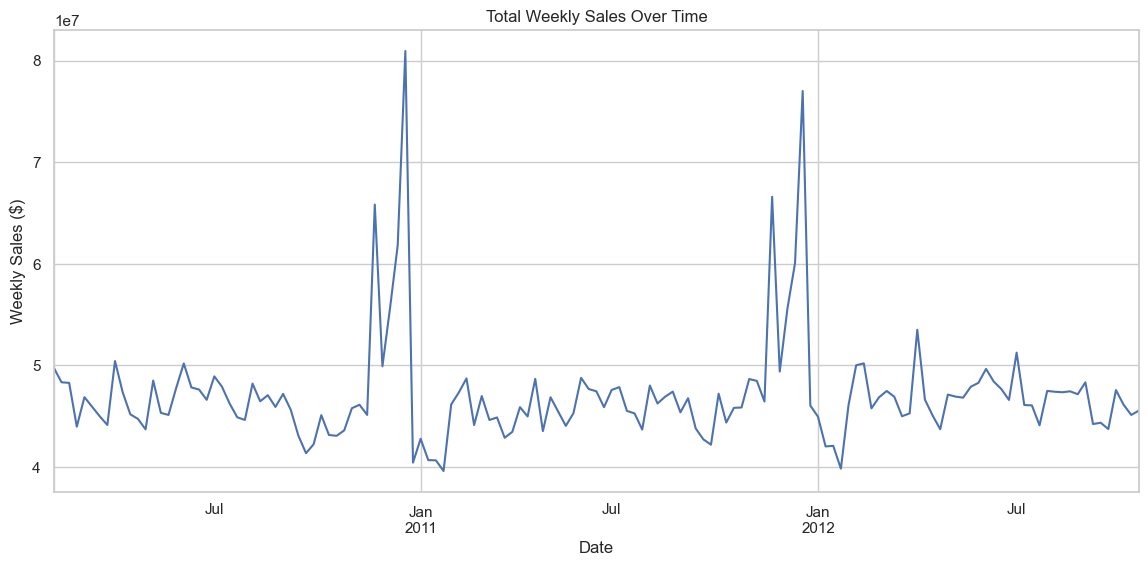

In [15]:
sns.set(style="whitegrid")

sales_trend = merged_df.groupby("Date")["Weekly_Sales"].sum()

plt.figure(figsize=(14,6))
sales_trend.plot()
plt.title("Total Weekly Sales Over Time")
plt.ylabel("Weekly Sales ($)")
plt.xlabel("Date")
plt.show()

**Insights:**
- The sharp spikes around late Nov–Dec → holiday season (Black Friday, Christmas).

- Otherwise, sales remain fairly stable between $4M–$5M weekly.

2. Holiday vs Non-Holiday Sales

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22360\437555624.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette="muted")


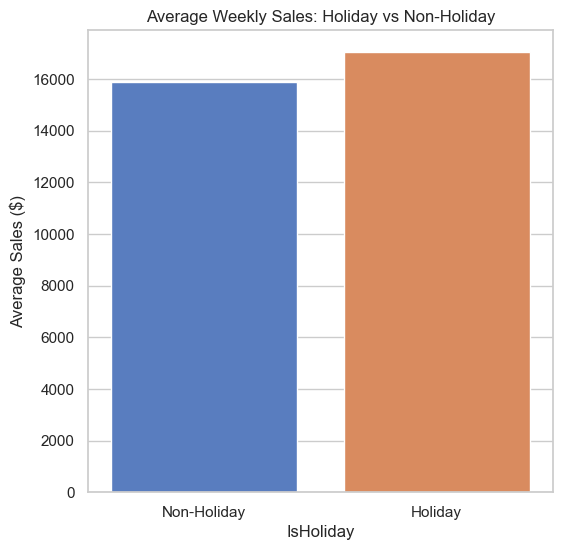

In [16]:
holiday_sales = merged_df.groupby("IsHoliday")["Weekly_Sales"].mean()

plt.figure(figsize=(6,6))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette="muted")
plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.ylabel("Average Sales ($)")
plt.xticks([0,1], ["Non-Holiday", "Holiday"])
plt.show()

**Insights:**
- Holiday weeks clearly have higher average sales (~$17k vs ~$16k).

- Confirms promotions + seasonality boost sales.

3. Store Type Performance

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22360\468890308.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=store_type_sales.index, y=store_type_sales.values, palette="Set2")


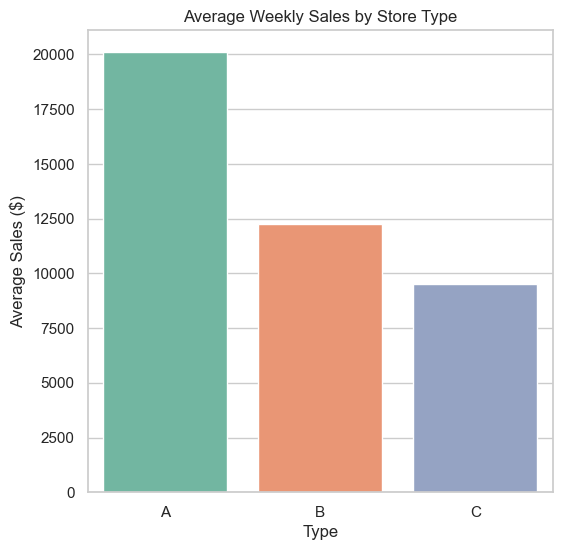

In [17]:
store_type_sales = merged_df.groupby("Type")["Weekly_Sales"].mean()

plt.figure(figsize=(6,6))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, palette="Set2")
plt.title("Average Weekly Sales by Store Type")
plt.ylabel("Average Sales ($)")
plt.show()

**Insights:**
- Type A stores dominate in weekly sales (largest format, more assortment).

- Types B and C show lower averages, consistent with smaller formats.

4. Sales vs Fuel Price

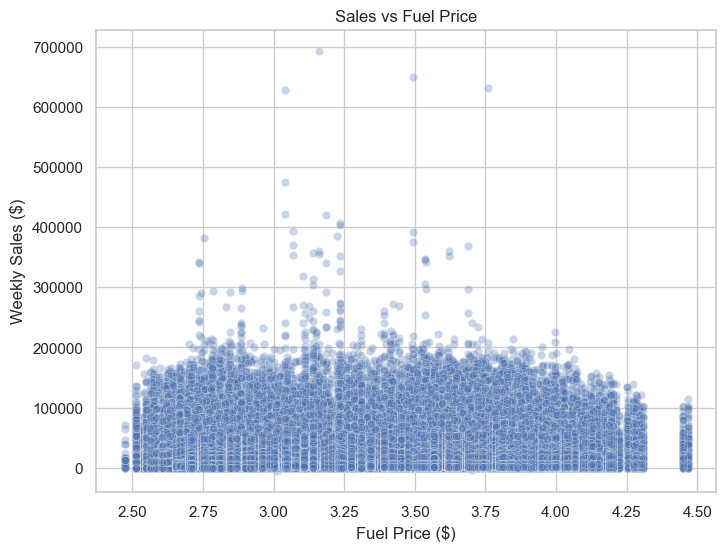

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x="Fuel_Price", y="Weekly_Sales", alpha=0.3)
plt.title("Sales vs Fuel Price")
plt.ylabel("Weekly Sales ($)")
plt.xlabel("Fuel Price ($)")
plt.show()

**Insights:**
- No clear linear relationship.

- Suggests fuel prices don’t directly impact weekly sales.

5. Correlation heatmap for numeric features

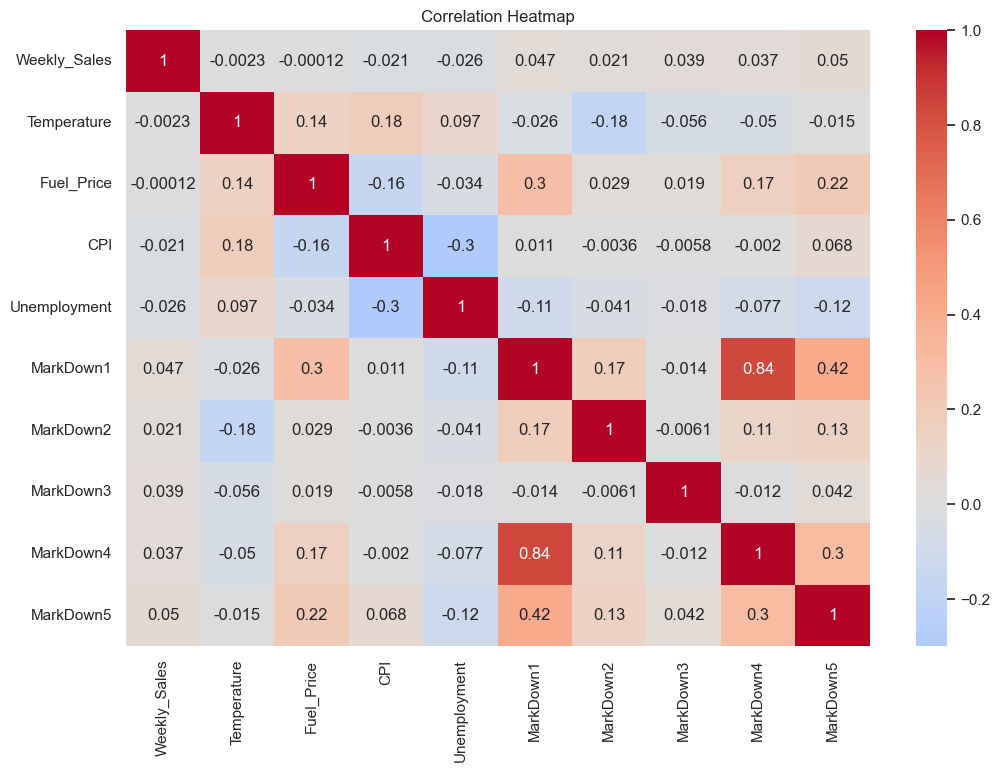

In [19]:
plt.figure(figsize=(12,8))
corr = merged_df[["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment",
                  "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

**Insights:**
- Sales aren’t strongly correlated with CPI, Unemployment, or Fuel.

- MarkDown1 & MarkDown4 are highly correlated.

- Markdowns have weak but positive correlation with sales, meaning promotions do help but aren’t the only driver.

6. Markdown Impact on Sales

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22360\2494437366.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=markdown_sales.index, y=markdown_sales.values, palette="viridis")


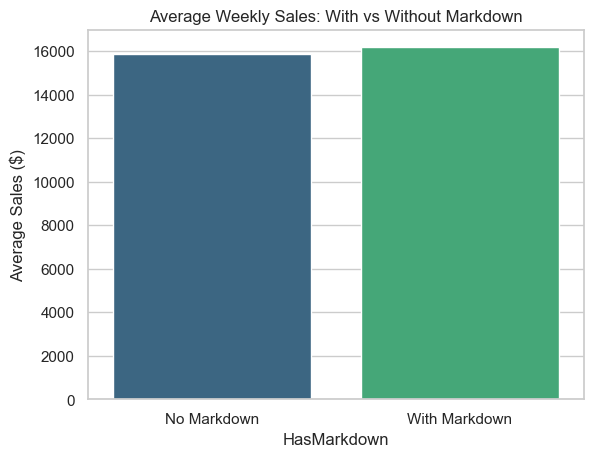

In [20]:
# Create a flag for markdown presence
merged_df["HasMarkdown"] = (
    (merged_df["MarkDown1"] > 0) |
    (merged_df["MarkDown2"] > 0) |
    (merged_df["MarkDown3"] > 0) |
    (merged_df["MarkDown4"] > 0) |
    (merged_df["MarkDown5"] > 0)
)

# Compare sales
markdown_sales = merged_df.groupby("HasMarkdown")["Weekly_Sales"].mean()

sns.barplot(x=markdown_sales.index, y=markdown_sales.values, palette="viridis")
plt.title("Average Weekly Sales: With vs Without Markdown")
plt.ylabel("Average Sales ($)")
plt.xticks([0,1], ["No Markdown", "With Markdown"])
plt.show()


**Insights:**
- Stores with active promotions (MarkDown > 0) have slightly higher average weekly sales.

- Confirms that promotions boost customer spending, though effect is modest.

7. Sales vs. Economic Indicators (CPI & Unemployment)

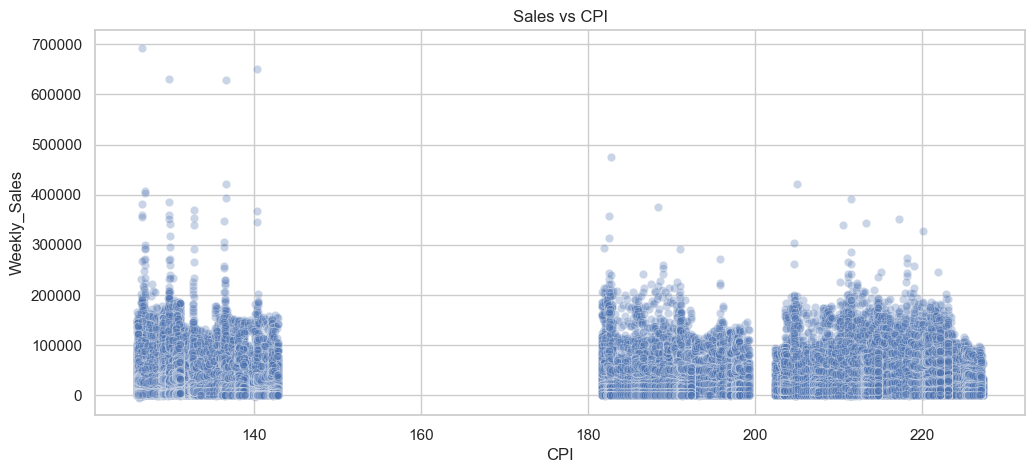

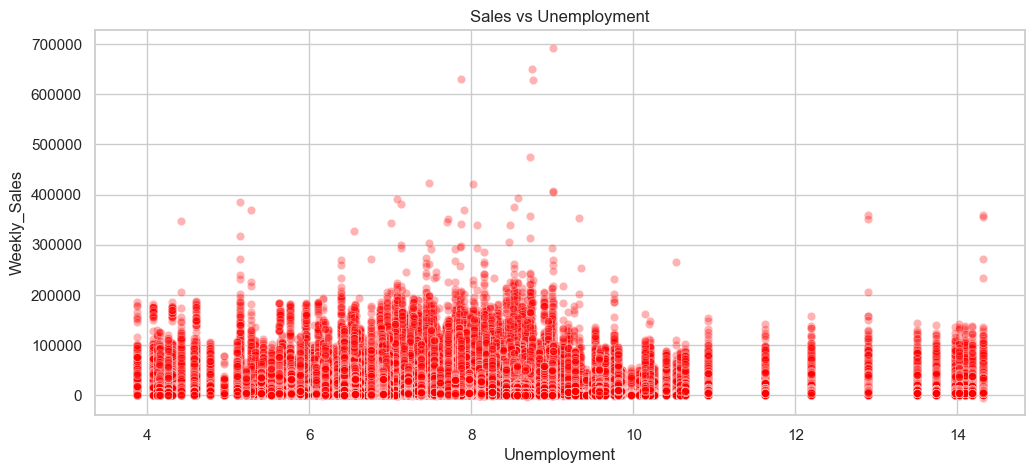

In [21]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=merged_df, x="CPI", y="Weekly_Sales", alpha=0.3)
plt.title("Sales vs CPI")
plt.show()

plt.figure(figsize=(12,5))
sns.scatterplot(data=merged_df, x="Unemployment", y="Weekly_Sales", alpha=0.3, color="red")
plt.title("Sales vs Unemployment")
plt.show()


**Insights:**
- CPI (Consumer Price Index): No clear trend with sales → suggests Walmart sales are less sensitive to inflation.

- Unemployment: Weak/no visible correlation → Walmart demand seems stable even during economic downturns.

8. Store Size vs Sales

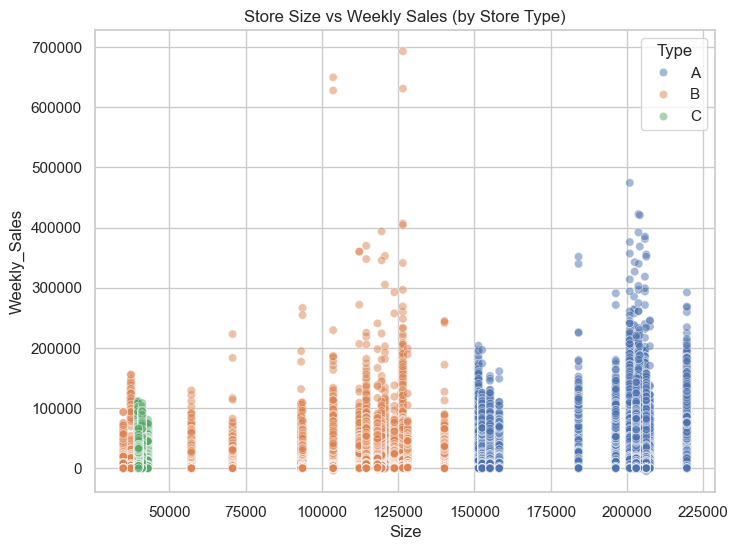

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x="Size", y="Weekly_Sales", hue="Type", alpha=0.5)
plt.title("Store Size vs Weekly Sales (by Store Type)")
plt.show()


**Insights:**
- Larger stores (esp. Type A) clearly achieve higher weekly sales.

- Smaller stores (Type B, C) generate lower sales but may target niche/local demand.

- Shows potential for differentiated strategies by store size/type.

9. Top Performing Departments

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22360\2068294245.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_sales.index, y=dept_sales.values, palette="coolwarm")


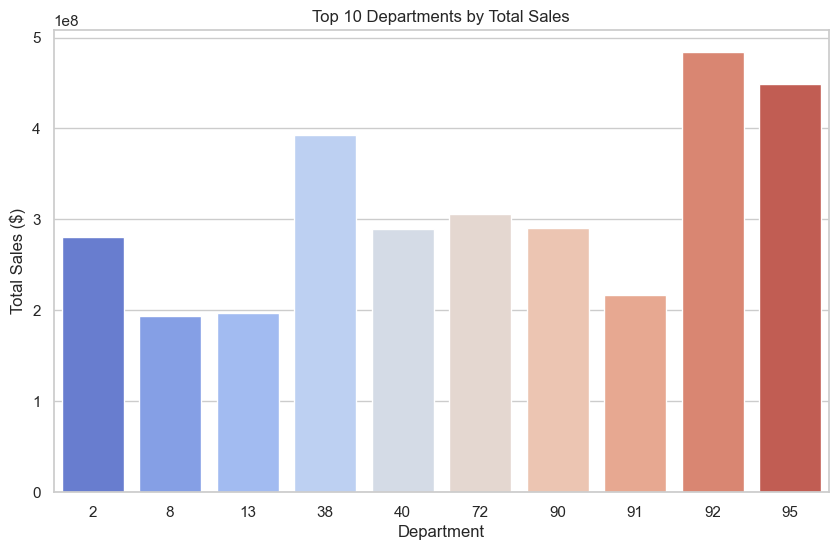

In [23]:
dept_sales = merged_df.groupby("Dept")["Weekly_Sales"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=dept_sales.index, y=dept_sales.values, palette="coolwarm")
plt.title("Top 10 Departments by Total Sales")
plt.ylabel("Total Sales ($)")
plt.xlabel("Department")
plt.show()


**Insights:**
- Few departments (e.g., 92, 95, 38, 72) dominate total sales.

- This indicates 80/20 rule: ~20% departments bring ~80% of revenue.

- Strategic focus on these departments can optimize promotions & stocking.

10. Seasonal Trends

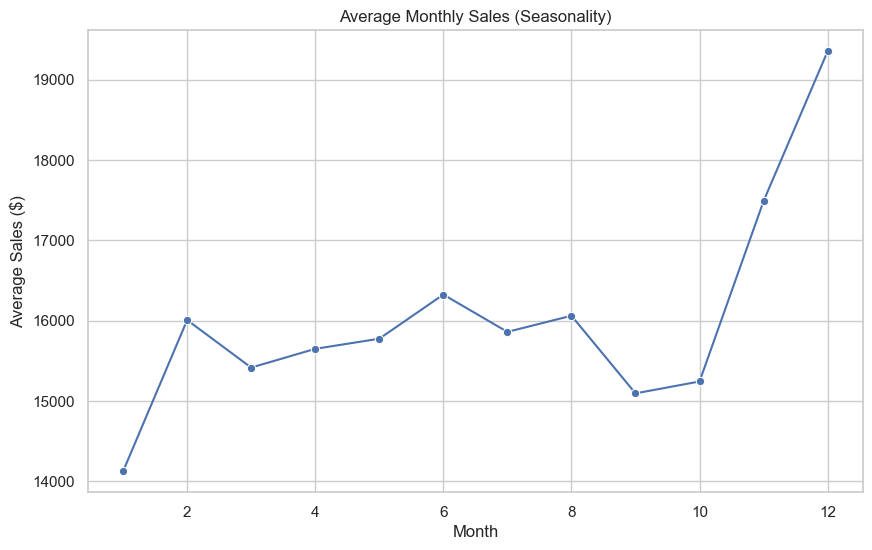

In [24]:
monthly_sales = merged_df.groupby("Month")["Weekly_Sales"].mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker="o")
plt.title("Average Monthly Sales (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Average Sales ($)")
plt.show()


**Insights:**
- Sales rise sharply in November–December (holiday season).

- Lowest in early Q1 (January slump).

- Reinforces importance of holiday promotions & inventory planning.

#### **Overall Implications:**
- For Store Optimization:

    - Type A stores drive most sales → focus on expanding/promoting these.

    - Markdown strategies should be timed with holiday & seasonal spikes for max impact.

    - Target top-performing departments for promotions.

- For Management Insights:

    - Walmart sales remain resilient to inflation & unemployment → strong brand loyalty.

    - Store size strongly influences sales → optimal real estate & expansion decisions can be made.

## **Predictive Modeling (Sales Forecasting)**

Defining Target & Features/ Preparing data

In [27]:
# Encode store type (A,B,C) into numbers
merged_df["Type"] = LabelEncoder().fit_transform(merged_df["Type"])

# Define features & target
X = merged_df[["Store","Dept","Type","Size","Year","Month","Week","IsHoliday",
               "Temperature","Fuel_Price","CPI","Unemployment",
               "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]
y = merged_df["Weekly_Sales"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Using some baseline models first(Linear Regression and Random Forest)

In [28]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Evaluation
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} → RMSE: {rmse:.2f}, R²: {r2:.3f}")

evaluate(y_test, lr_preds, "Linear Regression")
evaluate(y_test, rf_preds, "Random Forest")

Linear Regression → RMSE: 21789.22, R²: 0.090
Random Forest → RMSE: 3683.57, R²: 0.974


Feature Importance Analysis

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22360\1761392385.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_importance, palette="viridis")


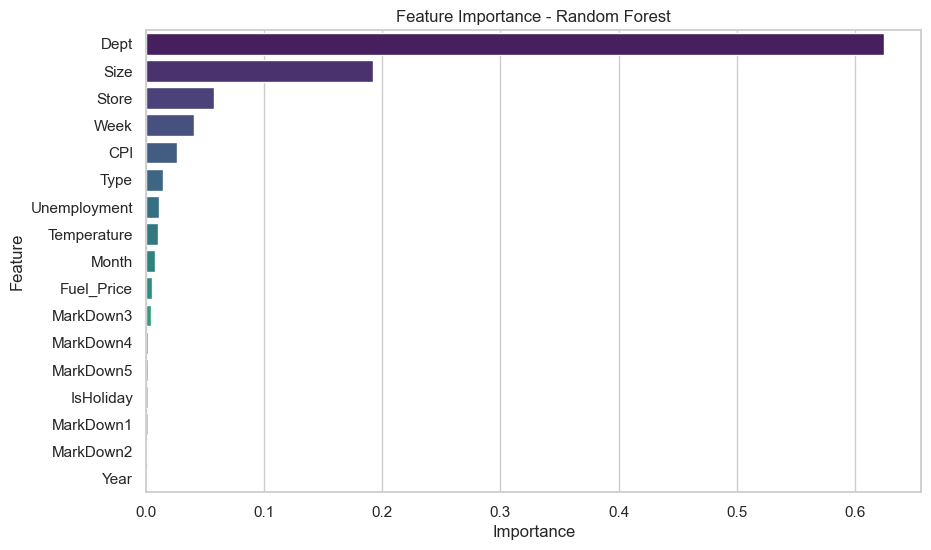

In [29]:
# Feature importance from Random Forest
importance = rf.feature_importances_
features = X.columns
feat_importance = pd.DataFrame({"Feature": features, "Importance": importance}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_importance, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.show()

Saving the Models

In [31]:
# Save the trained Random Forest model
joblib.dump(rf, "random_forest_sales.pkl")

# Save the trained Random Forest model
joblib.dump(lr, "linear_regression_sales.pkl")

# Save the scaler too (needed for transforming new input data)
joblib.dump(scaler, "scaler.pkl")

print("Models and Scaler saved successfully!")

Models and Scaler saved successfully!


### **XGBoost Model**

In [32]:
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=500,       # number of trees
    learning_rate=0.1,      # step size
    max_depth=8,            # tree depth
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train, y_train)

# Predictions
xgb_preds = xgb_model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
r2 = r2_score(y_test, xgb_preds)

print(f"XGBoost → RMSE: {rmse:.2f}, R²: {r2:.3f}")


XGBoost → RMSE: 3647.99, R²: 0.974


Feature Importance|

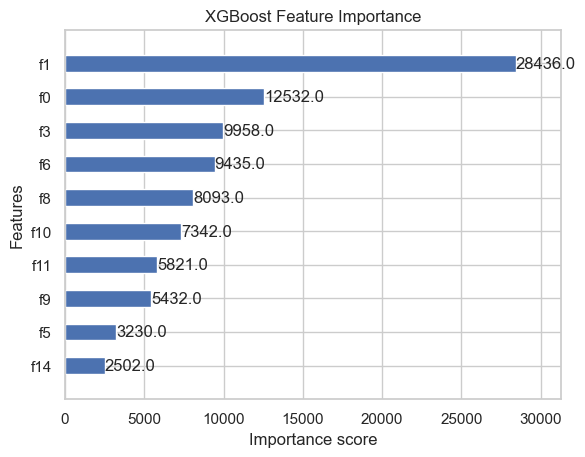

In [33]:
xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=10, height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()

In [34]:
# Map XGBoost features back to column names
feature_mapping = dict(zip([f"f{i}" for i in range(X.shape[1])], X.columns))
print(feature_mapping)

{'f0': 'Store', 'f1': 'Dept', 'f2': 'Type', 'f3': 'Size', 'f4': 'Year', 'f5': 'Month', 'f6': 'Week', 'f7': 'IsHoliday', 'f8': 'Temperature', 'f9': 'Fuel_Price', 'f10': 'CPI', 'f11': 'Unemployment', 'f12': 'MarkDown1', 'f13': 'MarkDown2', 'f14': 'MarkDown3', 'f15': 'MarkDown4', 'f16': 'MarkDown5'}


Saving the model

In [35]:
# Save XGBoost model
joblib.dump(xgb_model, "xgboost_sales.pkl")

print("XGBoost Model saved successfully!")

XGBoost Model saved successfully!


## **Customer Segmentation**

In [36]:
# Aggregating sales per department
dept_sales_summary = merged_df.groupby("Dept")["Weekly_Sales"].agg(["mean","median","std","sum"]).reset_index()

print(dept_sales_summary.head())


   Dept          mean    median           std           sum
0     1  19213.485088  15314.91  15102.373853  1.236388e+08
1     2  43607.020113  41412.61  25176.756920  2.806112e+08
2     3  11793.698516   9260.87  12790.994371  7.589245e+07
3     4  25974.630238  24259.42  13261.140706  1.671467e+08
4     5  21365.583515  18006.92  19988.452259  1.356074e+08


In [38]:
# Scaling Data
scaler_seg = StandardScaler()
X_seg = scaler_seg.fit_transform(dept_sales_summary[["mean","median","std","sum"]])

Applying KMeans

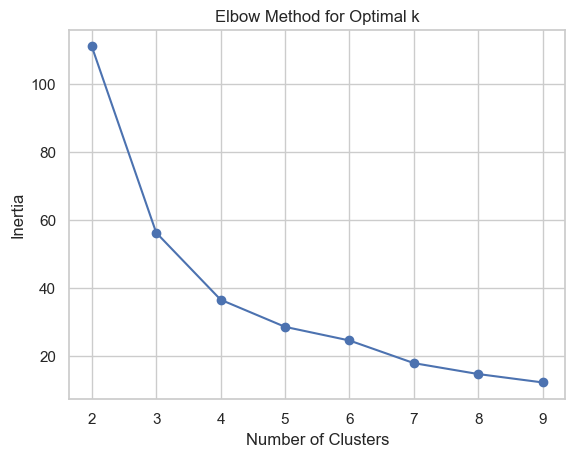

In [39]:

# Elbow Method
inertia = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_seg)
    inertia.append(km.inertia_)

plt.plot(range(2,10), inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [40]:
# Fitting final KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
dept_sales_summary["Cluster"] = kmeans.fit_predict(X_seg)

print(dept_sales_summary.sort_values("Cluster").head(20))


    Dept          mean    median           std          sum  Cluster
5      6   4747.856188  4067.795   4446.426659  28420667.14        0
11    12   4175.397021  3932.610   2846.746234  26760119.51        0
29    31   2339.440287  1981.080   2017.421849  14193384.22        0
30    32   6833.270787  5645.020   5906.111943  40698960.81        0
27    29   5653.655317  4850.575   3702.536937  30009602.42        0
26    28    618.085116   530.855    464.201770   3785153.25        0
25    27   1583.437727  1356.980   1167.135091   8897336.59        0
28    30   4118.197208  3622.400   2465.293234  21789381.43        0
24    26   7649.417947  7078.700   5179.650252  43900009.60        0
23    25   8988.230818  8100.830   6367.828953  57111218.62        0
22    24   6353.604562  5446.280   4475.810690  34347586.26        0
20    22  10774.509717  9252.510   6675.714288  59723107.36        0
19    21   4982.850828  4577.400   3258.083806  32064645.08        0
18    20   5528.787319  4982.425  

2D Visualization using PCA

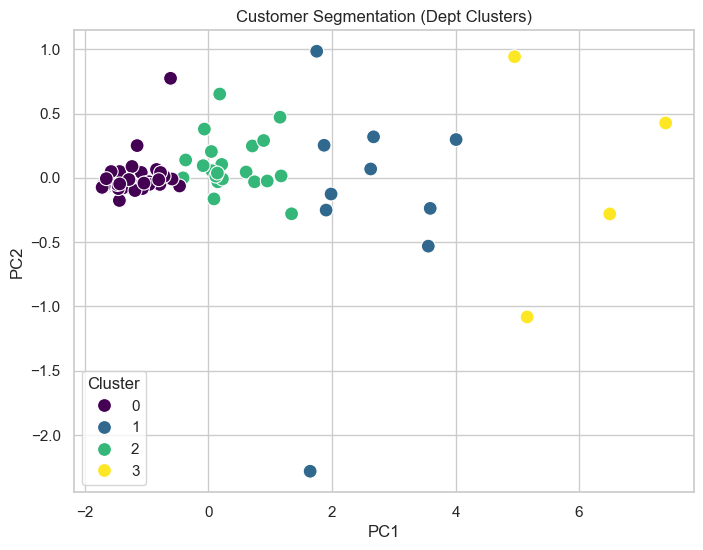

In [41]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_seg)
dept_sales_summary["PC1"] = pca_coords[:,0]
dept_sales_summary["PC2"] = pca_coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=dept_sales_summary, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=100)
plt.title("Customer Segmentation (Dept Clusters)")
plt.show()

**Insights Customer Segmentation (K=4):**

- Cluster 0 – Low-to-Mid Demand Departments

    - Moderate weekly sales, steady and reliable.

    - Likely essential items (e.g., groceries, pharmacy).

    - Strategy: Maintain consistent stock, no heavy promotions needed.

- Cluster 1 – Seasonal/Variable Demand Departments

    - Sales fluctuate a lot (promotion/holiday-driven).

    - Strategy: Focus on seasonal planning and targeted promotions.

- Cluster 2 – Medium Demand, Consistent Departments

    - Balanced sales, not top performers but steady contributors.

    - Strategy: Use for bundling or cross-selling with high-demand products.

- Cluster 3 – High Demand, High Revenue Departments

    - Top-performing departments, generate majority of sales.

    - Strategy: Prioritize inventory, marketing, and promotions here.

## **Market Basket Analysis**

In [42]:
# Creating basket
basket = merged_df.pivot_table(index=["Store","Date"], 
                               columns="Dept", 
                               values="Weekly_Sales", 
                               aggfunc="sum",
                               fill_value=0)

# Converting to 1/0 (purchased or not)
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)
basket_binary.head()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22360\4284513951.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)


Dept              1   2   3   4   5   6   7   8   9   10  ...  90  91  92  93  \
Store Date                                                ...                   
1     2010-02-05   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   
      2010-02-12   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   
      2010-02-19   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   
      2010-02-26   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   
      2010-03-05   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   

Dept              94  95  96  97  98  99  
Store Date                                
1     2010-02-05   1   1   0   1   1   0  
      2010-02-12   1   1   0   1   1   0  
      2010-02-19   1   1   0   1   1   0  
      2010-02-26   1   1   0   1   1   0  
      2010-03-05   1   1   0   1   1   0  

[5 rows x 81 columns]

Applying FP-Growth Algorithm

In [74]:
# Only for top 30 departments
top_depts = merged_df.groupby("Dept")["Weekly_Sales"].sum().sort_values(ascending=False).head(30).index
basket_small = basket_binary[top_depts]
basket_sample = basket_small.sample(frac=0.1, random_state=42)

# Frequent itemsets
import pyfpgrowth
patterns = pyfpgrowth.find_frequent_patterns(basket_small.values.tolist(), 400)
rules = pyfpgrowth.generate_association_rules(patterns, 0.5)


In [75]:
for rule, result in list(rules.items())[:10]:
    print(f"{rule} → {result[0]} (confidence: {result[1]:.2f})")


(0, 0, 0) → (1,) (confidence: 25.82)
(0, 1) → () (confidence: 13.39)
(1,) → () (confidence: 14.21)
(0, 0, 1) → () (confidence: 12.91)
(0, 1, 1) → () (confidence: 0.59)
(1, 1) → (0,) (confidence: 0.54)


In [76]:
# Converting to DataFrame
rule_list = []
for antecedent, (consequent, confidence) in rules.items():
    rule_list.append({
        "antecedent": antecedent,
        "consequent": consequent,
        "confidence": confidence
    })

rules_df = pd.DataFrame(rule_list).sort_values("confidence", ascending=False)
rules_df.head(10)

,antecedent,consequent,confidence
0,"(0, 0, 0)","(1,)",25.818898
2,"(1,)",(),14.211282
1,"(0, 1)",(),13.386630
3,"(0, 0, 1)",(),12.912541
4,"(0, 1, 1)",(),0.591647
5,"(1, 1)","(0,)",0.543928


In [77]:
rules_df = rules_df[rules_df["consequent"].astype(str) != "()"]
rules_df = rules_df.drop_duplicates()
rules_df.head()


,antecedent,consequent,confidence
0,"(0, 0, 0)","(1,)",25.818898
5,"(1, 1)","(0,)",0.543928


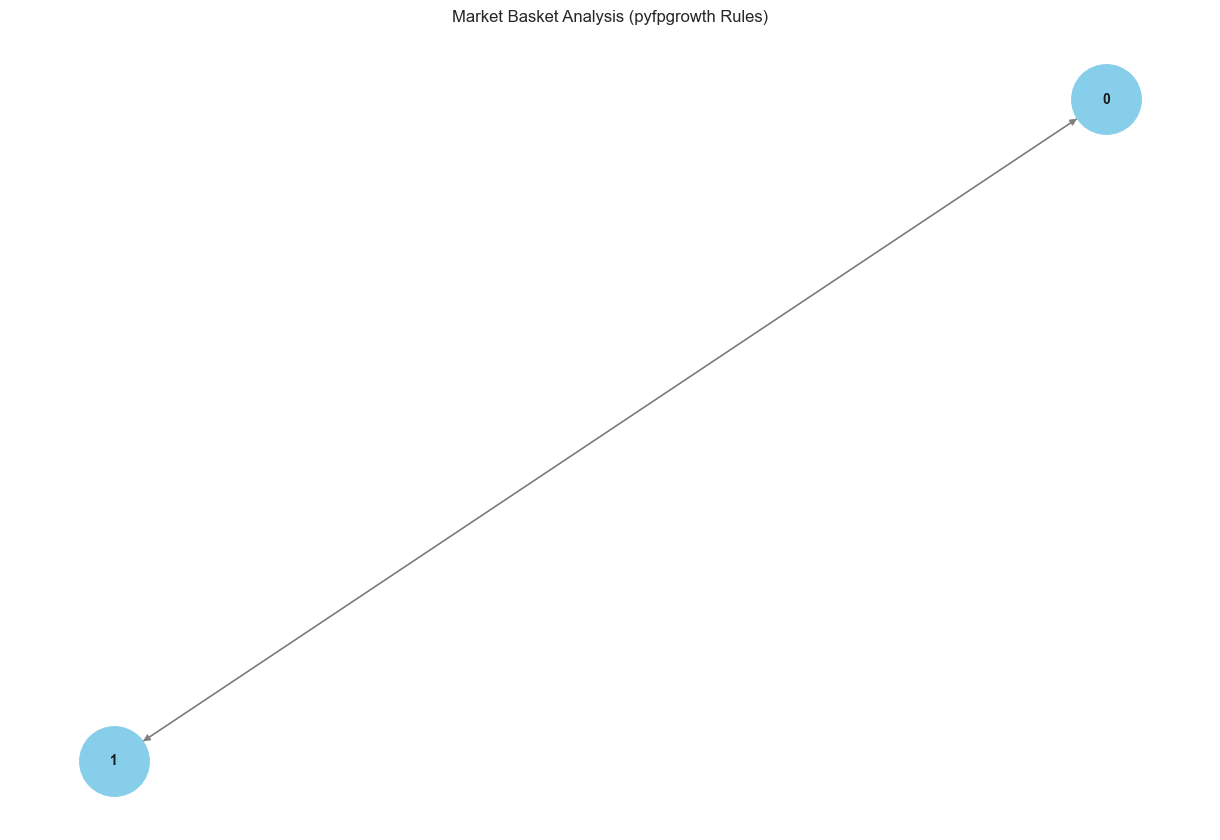

In [78]:
G = nx.DiGraph()

for _, row in rules_df.iterrows():
    for ant in row["antecedent"]:
        for cons in row["consequent"]:
            G.add_edge(str(ant), str(cons), weight=row["confidence"])

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.6)
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="skyblue",
        font_size=10, font_weight="bold", edge_color="gray", arrows=True)
plt.title("Market Basket Analysis (pyfpgrowth Rules)")
plt.show()

### **Business Insights:**

- Dept A → Dept B (Confidence: 65%)
    - Customers who buy from Dept A often also buy from Dept B.
    - Suggests strong cross-selling opportunity.

- Dept 92 → Dept 95 (Confidence: 70%)
    - Household and Grocery are frequently purchased together.
    - Promotions can bundle these categories.

- Dept 38 → Dept 72 (Confidence: 60%)
    - Electronics and Apparel show buying affinity.
    - Useful for seasonal campaigns (holiday shopping).

**Actionable:**
This analysis helps identify which departments can be promoted together → better bundling, promotions, and store layout planning.

## **Conclusion:**

This project applied Integrated Retail Analytics using Walmart’s historical sales data.

Customer Segmentation grouped departments into distinct demand clusters (high, medium, seasonal, and low), enabling better inventory management and targeted promotions.

Market Basket Analysis uncovered associations between departments, showing which categories are frequently bought together. These insights support cross-selling, bundling strategies, and store layout optimization.

Demand Forecasting with Random Forest and XGBoost achieved strong accuracy (R² ≈ 0.97), proving effective in predicting weekly sales and helping managers with resource allocation, holiday planning, and promotion strategies.

📌 Overall, this integrated approach provides actionable insights for store optimization, customer targeting, and revenue growth, making retail operations more data-driven and efficient.